## 数据的准备工作
1. 切割土地利用图
2. 切割航空影像数据
3. 分离训练和测试数据

In [1]:
import os, os.path
from path import Path
import shutil
import rasterio as rio
import rasterio
from rasterio.windows import get_data_window
from rasterio.windows import Window
import rasterio.mask
import json
from shapely.geometry import Polygon
import random
import numpy as np
import argparse

### 1. 切割土地利用图数据

In [2]:

def raster2tiles(input_value_raster, tile_width_in, tile_height_in, outfolder): 
    '''This is function is used to clip the raster data into many smaller 
    fixed size of tiles
    
    Parameter: 
        input_value_raster: the filename of the input raster
        tile_width_in: the specified tile width
        tile_height_in: the specified tile height
        outfolder: the ouput dsm folder
    '''
    
    lu_dataset = rasterio.open(input_value_raster)
    lu_img = lu_dataset.read()
    
    # height and width of the raster
    height, width = lu_dataset.shape

    # split the large raser into number of tiles, tile size is 2000*2000
    tile_width = tile_width_in
    tile_height = tile_height_in

    tile_num_col = int(width/tile_width + 0.5)
    tile_num_row = int(height/tile_height + 0.5)

    # the output folder
    if not os.path.exists(outfolder): os.mkdir(outfolder)

    # create each tile
    for i in range(tile_num_row):
        # re-initiate the tile width when reach the right boundary
        tile_width = tile_width_in
        row_start = i*tile_height

        # loop each column
        for j in range(tile_num_col):
            print('The i and j is:', i, j)
            tilename = os.path.join(outfolder, 'row%s-col%s.tif'%(i, j))
            
            col_start = j*tile_width
            row_end = (i + 1)*tile_height
            col_end = (j + 1)*tile_width
            
            # deal with the right boundary
            if row_end > height - 1: tile_height = height - row_start
            if col_end > width - 1: tile_width = width - col_start
            
            # window = get_data_window(lu_dataset.read(1, masked=True))
            window = Window(col_off=col_start, row_off=row_start, width=tile_width, height=tile_height)
            
            kwargs = lu_dataset.meta.copy()
            kwargs.update({
                'height': window.height,
                'width': window.width,
                'transform': rasterio.windows.transform(window, lu_dataset.transform)})
            
            img_window = lu_dataset.read(window=window)
            if img_window.min() <= 0: continue
            with rasterio.open(tilename, 'w', **kwargs) as dst:
                dst.write(img_window)


In [13]:
root = '/data/deeplearn-cities/dataset'

# landcover_file = os.path.join(root, 'lu_phily.tif')
# naip_file = os.path.join(root, 'proj-philadelphia-naip.tif')
landcover_file = os.path.join(root, 'landuse.tif')
naip_file = os.path.join(root, 'naip.tif')


# configure the training data folder
folder1 = os.path.join(root, 'dataset')
if not os.path.exists(folder1): os.mkdir(folder1)
foldertraining = os.path.join(folder1, 'trainning')
if not os.path.exists(foldertraining): os.mkdir(foldertraining)
train_label_folder = os.path.join(foldertraining, 'labels')
if not os.path.exists(train_label_folder): os.mkdir(train_label_folder)


tile_width = 256
tile_height = 256

raster2tiles(landcover_file, tile_width, tile_height, train_label_folder)


The i and j is: 0 0
The i and j is: 0 1
The i and j is: 0 2
The i and j is: 0 3
The i and j is: 0 4
The i and j is: 0 5
The i and j is: 0 6
The i and j is: 0 7
The i and j is: 0 8
The i and j is: 0 9
The i and j is: 0 10
The i and j is: 0 11
The i and j is: 0 12
The i and j is: 0 13
The i and j is: 0 14
The i and j is: 0 15
The i and j is: 0 16
The i and j is: 0 17
The i and j is: 0 18
The i and j is: 0 19
The i and j is: 1 0
The i and j is: 1 1
The i and j is: 1 2
The i and j is: 1 3
The i and j is: 1 4
The i and j is: 1 5
The i and j is: 1 6
The i and j is: 1 7
The i and j is: 1 8
The i and j is: 1 9
The i and j is: 1 10
The i and j is: 1 11
The i and j is: 1 12
The i and j is: 1 13
The i and j is: 1 14
The i and j is: 1 15
The i and j is: 1 16
The i and j is: 1 17
The i and j is: 1 18
The i and j is: 1 19
The i and j is: 2 0
The i and j is: 2 1
The i and j is: 2 2
The i and j is: 2 3
The i and j is: 2 4
The i and j is: 2 5
The i and j is: 2 6
The i and j is: 2 7
The i and j is: 2 8


In [14]:
train_label_folder

'/data/deeplearn-cities/dataset/dataset/trainning/labels'

In [19]:
# ls /data/deeplearn-cities/dataset/dataset/trainning/labels

打开一个切片

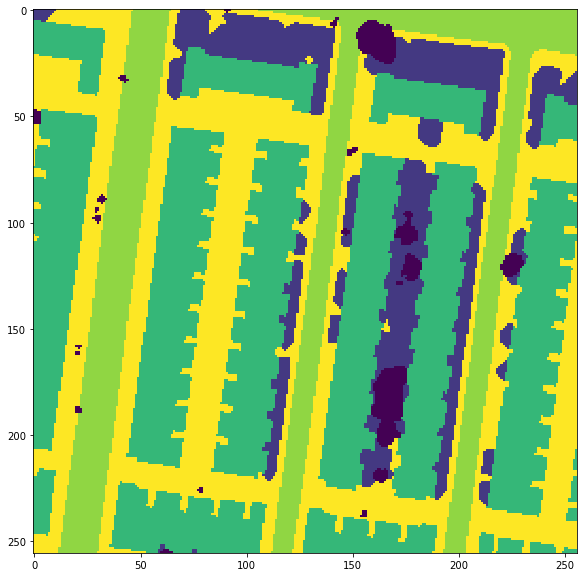

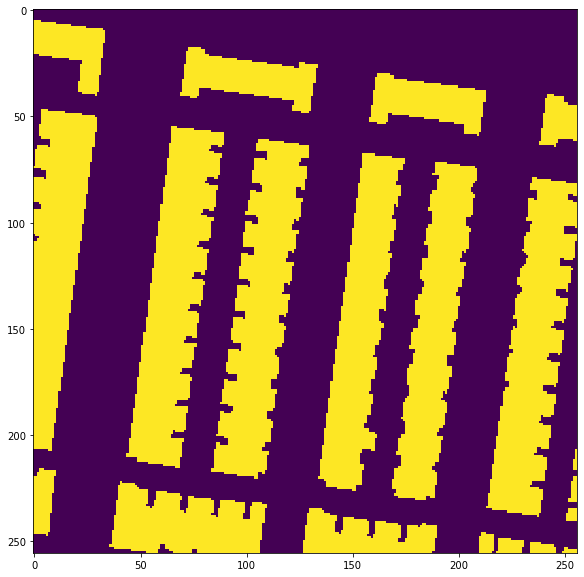

In [41]:
from matplotlib import pyplot as plt

tilefile = os.path.join(train_label_folder, 'row14-col0.tif')
lu_dataset = rasterio.open(tilefile)
lu_img = lu_dataset.read()
lu_img = lu_img.reshape(lu_img.shape[1], lu_img.shape[2])

plt.figure(figsize=(10, 10))
plt.imshow(lu_img)

plt.figure(figsize=(10, 10))
plt.imshow(lu_img == 5)

In [24]:
lu_img.shape

(1, 256, 256)

### 2. 基于切割好的土地利用图数据，进而切割航空影像，使用每个切片的边界信息考虑投影

In [27]:

def naip2tiles(naip_file, lu_folder, naip_tile_folder):
    '''
    Clip the NAIP tiles into tiles based on the size and geoinformation from the 
    clipped land use/cover tiles
    '''
    
    lu_dataset = rasterio.open(naip_file)
    lu_bounds = lu_dataset.bounds
    lu_box = Polygon([(lu_bounds.left, lu_bounds.bottom), \
                      (lu_bounds.left, lu_bounds.top), \
                      (lu_bounds.right, lu_bounds.top), \
                      (lu_bounds.right, lu_bounds.bottom)])
    
    for file in os.listdir(lu_folder):
        basename = os.path.basename(file)
        
        dem_data = rasterio.open(os.path.join(lu_folder, file))
        dem_bounds = dem_data.bounds
        left = dem_bounds.left
        bottom = dem_bounds.bottom
        right = dem_bounds.right
        top = dem_bounds.top    
        
        tile_box = Polygon([(left, bottom), \
                            (left, top), \
                            (right, top), \
                            (right, bottom)])
        
        # check if the dem tile is intersects with the big land use map
        overlap = lu_box.intersects(tile_box)
        if not overlap: continue
        
        print('The left, botton, right, and top are:', left, bottom, right, top)
        shape = [{'type': 'Polygon', 'coordinates': [[[left, top], [right, top], \
                                                      [right, bottom], [left, bottom], [left, top]]]}]
        
        
        # mask the raster using the polygon, if crop is False, the size would be extremely large
        out_image, out_transform = rasterio.mask.mask(lu_dataset, shape, crop=True)
        
        # prepare the schema of the new tiles
        out_meta = lu_dataset.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform,
                         "crs": lu_dataset.crs}
                       )
        
        out_tif = os.path.join(naip_tile_folder, basename)
        with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_image)


In [28]:
train_img_folder = os.path.join(foldertraining, 'imgs')
if not os.path.exists(train_img_folder): os.mkdir(train_img_folder)

naip2tiles(naip_file, train_label_folder, train_img_folder)


The left, botton, right, and top are: 2711597.4998999997 263919.1693 2712109.4998999997 264431.1693
The left, botton, right, and top are: 2713645.4998999997 260847.1693 2714157.4998999997 261359.1693
The left, botton, right, and top are: 2712109.4998999997 255215.1693 2712621.4998999997 255727.1693
The left, botton, right, and top are: 2714669.4998999997 263407.1693 2715181.4998999997 263919.1693
The left, botton, right, and top are: 2714157.4998999997 261359.1693 2714669.4998999997 261871.1693
The left, botton, right, and top are: 2715693.4998999997 261871.1693 2716205.4998999997 262383.1693
The left, botton, right, and top are: 2717741.4998999997 256239.1693 2718253.4998999997 256751.1693
The left, botton, right, and top are: 2719277.4998999997 259823.1693 2719789.4998999997 260335.1693
The left, botton, right, and top are: 2719789.4998999997 258799.1693 2720301.4998999997 259311.1693
The left, botton, right, and top are: 2715693.4998999997 254943.1693 2716205.4998999997 255215.1693


The left, botton, right, and top are: 2712109.4998999997 256751.1693 2712621.4998999997 257263.1693
The left, botton, right, and top are: 2716205.4998999997 262895.1693 2716717.4998999997 263407.1693
The left, botton, right, and top are: 2720301.4998999997 256751.1693 2720573.4998999997 257263.1693
The left, botton, right, and top are: 2718253.4998999997 262383.1693 2718765.4998999997 262895.1693
The left, botton, right, and top are: 2718253.4998999997 262895.1693 2718765.4998999997 263407.1693
The left, botton, right, and top are: 2715693.4998999997 256751.1693 2716205.4998999997 257263.1693
The left, botton, right, and top are: 2710573.4998999997 263919.1693 2711085.4998999997 264431.1693
The left, botton, right, and top are: 2717741.4998999997 258287.1693 2718253.4998999997 258799.1693
The left, botton, right, and top are: 2711085.4998999997 259311.1693 2711597.4998999997 259823.1693
The left, botton, right, and top are: 2716205.4998999997 261871.1693 2716717.4998999997 262383.1693


The left, botton, right, and top are: 2718253.4998999997 256751.1693 2718765.4998999997 257263.1693
The left, botton, right, and top are: 2717229.4998999997 256751.1693 2717741.4998999997 257263.1693
The left, botton, right, and top are: 2717229.4998999997 260847.1693 2717741.4998999997 261359.1693
The left, botton, right, and top are: 2711085.4998999997 260335.1693 2711597.4998999997 260847.1693
The left, botton, right, and top are: 2713133.4998999997 263919.1693 2713645.4998999997 264431.1693
The left, botton, right, and top are: 2715181.4998999997 257775.1693 2715693.4998999997 258287.1693
The left, botton, right, and top are: 2718253.4998999997 261359.1693 2718765.4998999997 261871.1693
The left, botton, right, and top are: 2712621.4998999997 260335.1693 2713133.4998999997 260847.1693
The left, botton, right, and top are: 2711085.4998999997 259823.1693 2711597.4998999997 260335.1693
The left, botton, right, and top are: 2715693.4998999997 263919.1693 2716205.4998999997 264431.1693


The left, botton, right, and top are: 2717741.4998999997 261359.1693 2718253.4998999997 261871.1693
The left, botton, right, and top are: 2715693.4998999997 255727.1693 2716205.4998999997 256239.1693
The left, botton, right, and top are: 2714669.4998999997 261871.1693 2715181.4998999997 262383.1693
The left, botton, right, and top are: 2720301.4998999997 258799.1693 2720573.4998999997 259311.1693
The left, botton, right, and top are: 2720301.4998999997 255727.1693 2720573.4998999997 256239.1693
The left, botton, right, and top are: 2720301.4998999997 263919.1693 2720573.4998999997 264431.1693
The left, botton, right, and top are: 2718253.4998999997 259311.1693 2718765.4998999997 259823.1693
The left, botton, right, and top are: 2718253.4998999997 260335.1693 2718765.4998999997 260847.1693
The left, botton, right, and top are: 2715693.4998999997 262895.1693 2716205.4998999997 263407.1693
The left, botton, right, and top are: 2714157.4998999997 258287.1693 2714669.4998999997 258799.1693


The left, botton, right, and top are: 2719277.4998999997 260847.1693 2719789.4998999997 261359.1693
The left, botton, right, and top are: 2720301.4998999997 257263.1693 2720573.4998999997 257775.1693
The left, botton, right, and top are: 2719789.4998999997 258287.1693 2720301.4998999997 258799.1693
The left, botton, right, and top are: 2713133.4998999997 263407.1693 2713645.4998999997 263919.1693
The left, botton, right, and top are: 2716205.4998999997 257263.1693 2716717.4998999997 257775.1693
The left, botton, right, and top are: 2716205.4998999997 264431.1693 2716717.4998999997 264943.1693
The left, botton, right, and top are: 2710573.4998999997 263407.1693 2711085.4998999997 263919.1693
The left, botton, right, and top are: 2720301.4998999997 260847.1693 2720573.4998999997 261359.1693
The left, botton, right, and top are: 2719789.4998999997 262383.1693 2720301.4998999997 262895.1693
The left, botton, right, and top are: 2714157.4998999997 256239.1693 2714669.4998999997 256751.1693


同样的道理，打开一个切片影像进行检查

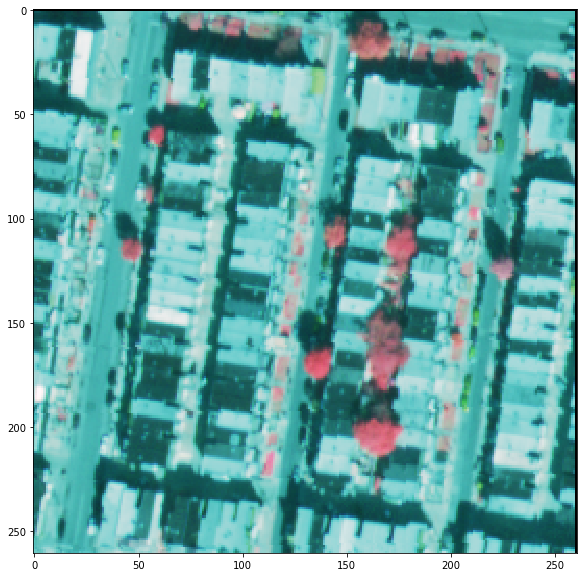

In [37]:
from matplotlib import pyplot as plt

tilefile = os.path.join(train_img_folder, 'row14-col0.tif')
naip_dataset = rasterio.open(tilefile)
naip_img = lu_dataset.read()
naip_img = naip_img.transpose(1, 2, 0)


plt.figure(figsize=(10, 10))
plt.imshow(naip_img)

In [42]:
naip_img.shape, lu_img.shape


((261, 261, 3), (256, 256))

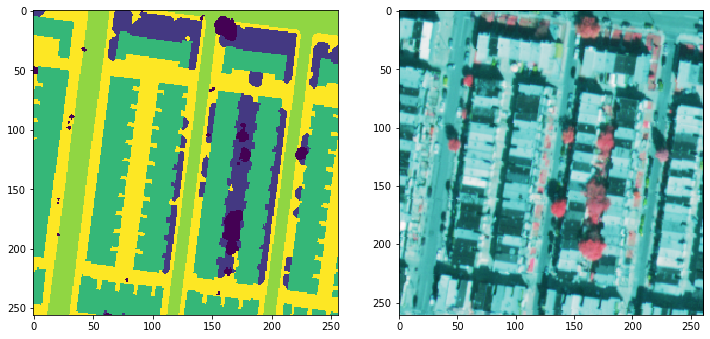

In [48]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2, figsize=(12,12)) 

axarr[0].imshow(lu_img)
axarr[1].imshow(naip_img)


### 3. 为了训练和测试，我们进一步把图像分为两部分，一部分用于训练，一部分用于测试

In [49]:

def split_train_validate(training_img_dir, training_labels_dir, validation_img_dir, validation_labels_dir, split = 5):
    '''split the training dataset into training and validationg parts, randomly
    select 20% of the training datast (imgs and labels) into the validation folder
    '''
    ## split the train dataset and validation dataset
    img_sample = random.sample(Path(training_img_dir).files(), len(Path(training_img_dir).files())//split )

    if not os.path.exists(validation_img_dir): os.mkdir(validation_img_dir)
    if not os.path.exists(validation_labels_dir): os.mkdir(validation_labels_dir)

    for i in img_sample:
        from_img_name = os.path.join(training_img_dir, i.name)
        shutil.move(os.path.join(training_img_dir, i.name), os.path.join(validation_img_dir, i.name))
        shutil.move(os.path.join(training_labels_dir, i.name), os.path.join(validation_labels_dir, i.name))


In [51]:
# the validataon folder
valid_folder = os.path.join(folder1, 'validation')
if not os.path.exists(valid_folder): os.mkdir(valid_folder)
valid_label_folder = os.path.join(valid_folder, 'labels')
if not os.path.exists(valid_label_folder): os.mkdir(valid_label_folder)
valid_img_folder = os.path.join(valid_folder, 'imgs')
if not os.path.exists(valid_img_folder): os.mkdir(valid_img_folder)


split_train_validate(train_img_folder, train_label_folder, valid_img_folder, valid_label_folder)
